# Relax Challenge

## Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
engagement = pd.read_csv('takehome_user_engagement.csv')
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
# Takehome users csv is not UTF-8 encoded
file_path = "/Users/celenelouise/Documents/Springboard/relax_challenge/takehome_users.csv"
users = pd.read_csv(file_path, encoding="ISO-8859-1")
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


#### Focusing on user engagment I will start by looking into the engagment df

In [7]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [8]:
# Going to convert time_stamp to a datetime
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [9]:
# Look at how many users 
num_users = len(engagement.user_id.unique())
num_users

8823

In [10]:
# Defining an adopted user
def is_adopted_user(engagement):
    adopted_users = set()
    for user_id, group in engagement.groupby('user_id'):
        group = group.set_index('time_stamp').resample('D').first().dropna()
        if len(group) >= 3:
            for i in range(len(group) - 2):
                if (group.index[i + 2] - group.index[i]) <= timedelta(days=7):
                    adopted_users.add(user_id)
                    break
    return adopted_users

In [11]:
# Run on all users returning adopted users
adopted_users = is_adopted_user(engagement)

#### Combining users & new col adopted users from engagement df

In [13]:
# Add a column to the users table indicating if the user is adopted
users['adopted_user'] = users['object_id'].apply(lambda x: 1 if x in adopted_users else 0)
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [14]:
# Count adopted users == 1
num_adopted = users['adopted_user'].sum()
num_adopted

1656

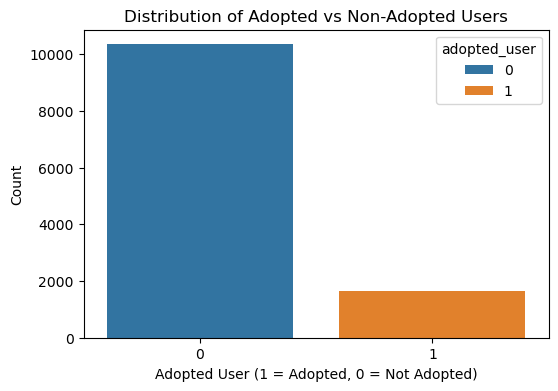

In [15]:
# Visualize adopted vs non-adopted users
plt.figure(figsize=(6, 4))
sns.countplot(x='adopted_user', data=users, hue='adopted_user')
plt.title('Distribution of Adopted vs Non-Adopted Users')
plt.xlabel('Adopted User (1 = Adopted, 0 = Not Adopted)')
plt.ylabel('Count')
plt.show()

In [16]:
# Drop unnecessary columns
users = users.drop(['name', 'email', 'object_id'], axis=1)

In [17]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               12000 non-null  object 
 1   creation_source             12000 non-null  object 
 2   last_session_creation_time  8823 non-null   float64
 3   opted_in_to_mailing_list    12000 non-null  int64  
 4   enabled_for_marketing_drip  12000 non-null  int64  
 5   org_id                      12000 non-null  int64  
 6   invited_by_user_id          6417 non-null   float64
 7   adopted_user                12000 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 750.1+ KB


In [18]:
# Since we are missing values by invited by user we are going to fill those as 0
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_time               12000 non-null  object 
 1   creation_source             12000 non-null  object 
 2   last_session_creation_time  8823 non-null   float64
 3   opted_in_to_mailing_list    12000 non-null  int64  
 4   enabled_for_marketing_drip  12000 non-null  int64  
 5   org_id                      12000 non-null  int64  
 6   invited_by_user_id          12000 non-null  float64
 7   adopted_user                12000 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 750.1+ KB


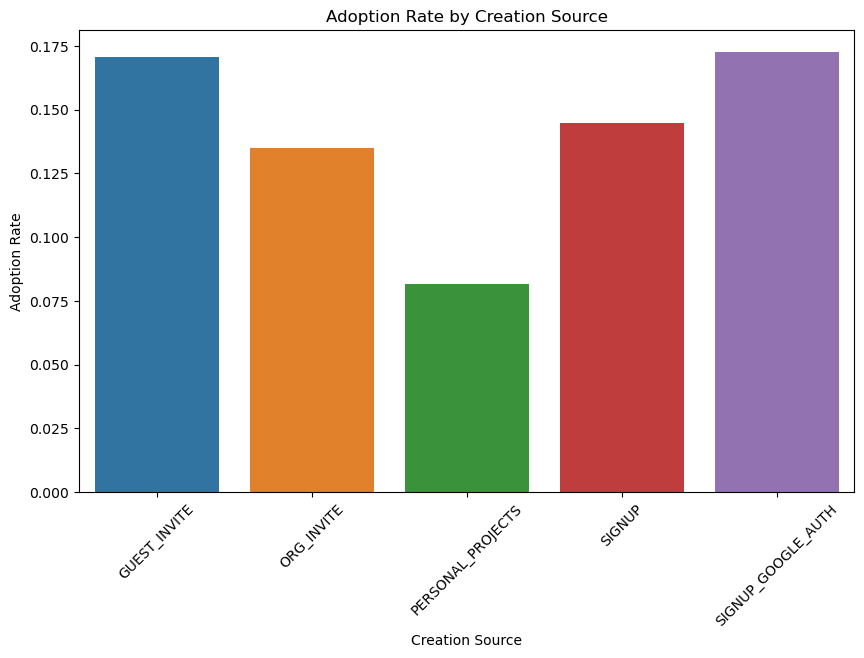

In [19]:
# Visualize adoption rate by creation source
# Calculate 
adoption_by_source = users.groupby('creation_source')['adopted_user'].mean().reset_index()

# Plot adoption rate by creation source
plt.figure(figsize=(10, 6))
sns.barplot(x='creation_source', y='adopted_user', data=adoption_by_source, hue='creation_source')
plt.title('Adoption Rate by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Adoption Rate')
plt.xticks(rotation=45)
plt.show()

#### **Looks like guest_invites and signups with google authentication tend to lead to higher adoption rates**

#### Now we can move on to feature engineering

In [22]:
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [23]:
# Calculate the number of days since creation and last session
users['days_since_creation'] = (pd.Timestamp.now() - users['creation_time']).dt.days
users['days_since_last_session'] = (pd.Timestamp.now() - users['last_session_creation_time']).dt.days

In [24]:
# Convert categorical variables to dummy variables
users = pd.get_dummies(users, columns=['creation_source'], drop_first=True)

In [25]:
# Drop unnecessary columns
users = users.drop(['creation_time', 'last_session_creation_time'], axis=1)

In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   opted_in_to_mailing_list            12000 non-null  int64  
 1   enabled_for_marketing_drip          12000 non-null  int64  
 2   org_id                              12000 non-null  int64  
 3   invited_by_user_id                  12000 non-null  float64
 4   adopted_user                        12000 non-null  int64  
 5   days_since_creation                 12000 non-null  int64  
 6   days_since_last_session             8823 non-null   float64
 7   creation_source_ORG_INVITE          12000 non-null  bool   
 8   creation_source_PERSONAL_PROJECTS   12000 non-null  bool   
 9   creation_source_SIGNUP              12000 non-null  bool   
 10  creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  bool   
dtypes: bool(4), float64(2), int64(5)
memory u

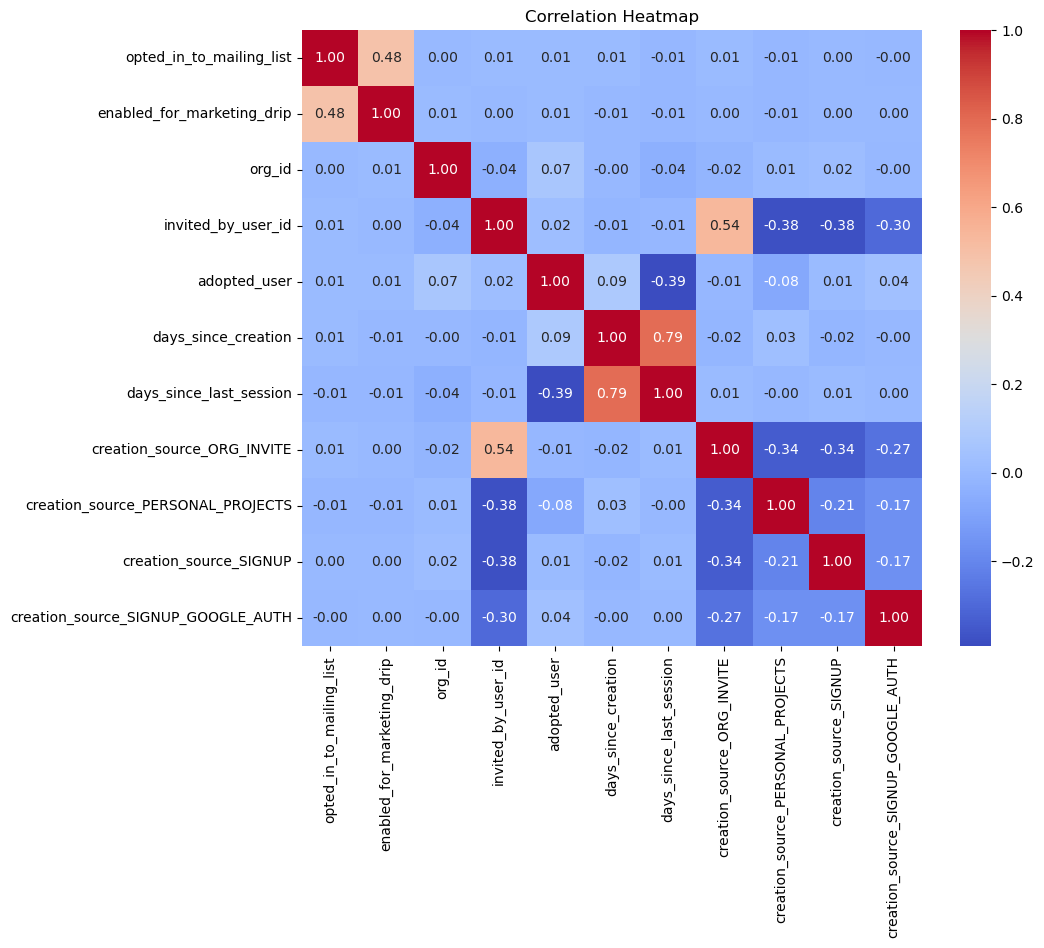

In [27]:
# Visualize correlation matrix
corr = users.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

#### Split & Train

In [29]:
# Split the data into features and target
X = users.drop('adopted_user', axis=1)
y = users['adopted_user']

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# Eval
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[2045   18]
 [  72  265]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2063
           1       0.94      0.79      0.85       337

    accuracy                           0.96      2400
   macro avg       0.95      0.89      0.92      2400
weighted avg       0.96      0.96      0.96      2400



#### Feature Importance

In [34]:
importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
print(feature_importances)

                              feature  importance
5             days_since_last_session    0.665886
4                 days_since_creation    0.214591
2                              org_id    0.060357
3                  invited_by_user_id    0.036804
0            opted_in_to_mailing_list    0.005070
1          enabled_for_marketing_drip    0.004263
6          creation_source_ORG_INVITE    0.004148
7   creation_source_PERSONAL_PROJECTS    0.003791
8              creation_source_SIGNUP    0.002611
9  creation_source_SIGNUP_GOOGLE_AUTH    0.002480


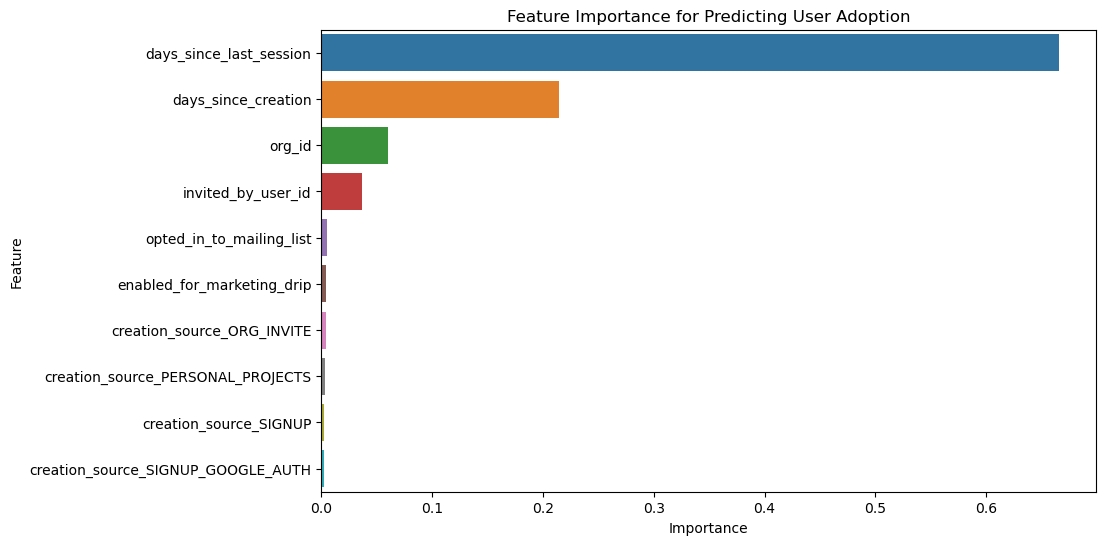

In [35]:
# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances, hue='feature')
plt.title('Feature Importance for Predicting User Adoption')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Since days since last session is our highest feature I am going to visulaize this and compare it to our adopted vs non-adopted users

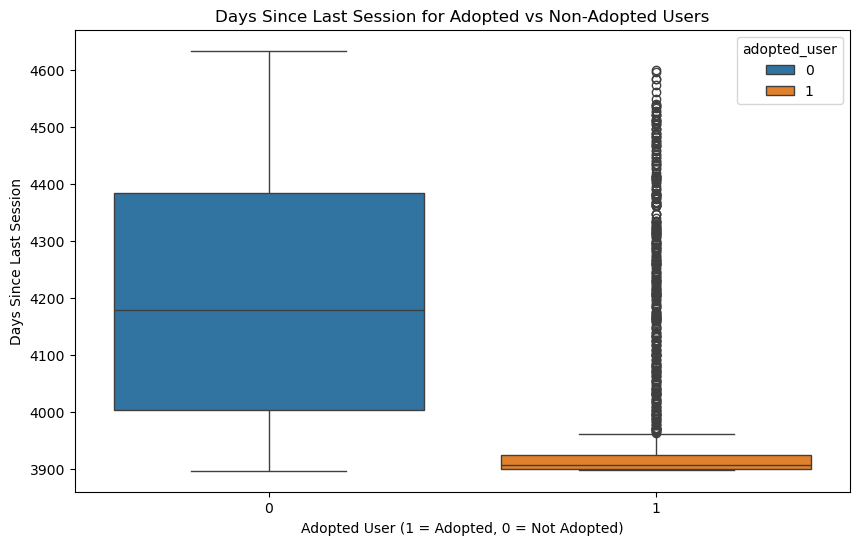

In [37]:
# Visualize distribution of days since last session
plt.figure(figsize=(10, 6))
sns.boxplot(x='adopted_user', y='days_since_last_session', data=users, hue='adopted_user')
plt.title('Days Since Last Session for Adopted vs Non-Adopted Users')
plt.xlabel('Adopted User (1 = Adopted, 0 = Not Adopted)')
plt.ylabel('Days Since Last Session')
plt.show()

#### Key take-away here is that the adopted user have much lower 'days since last session' meaning higher engagment. A good retention stragety would be to focus and encourage frequent usage early on.